# *dandelion* Notebook-2
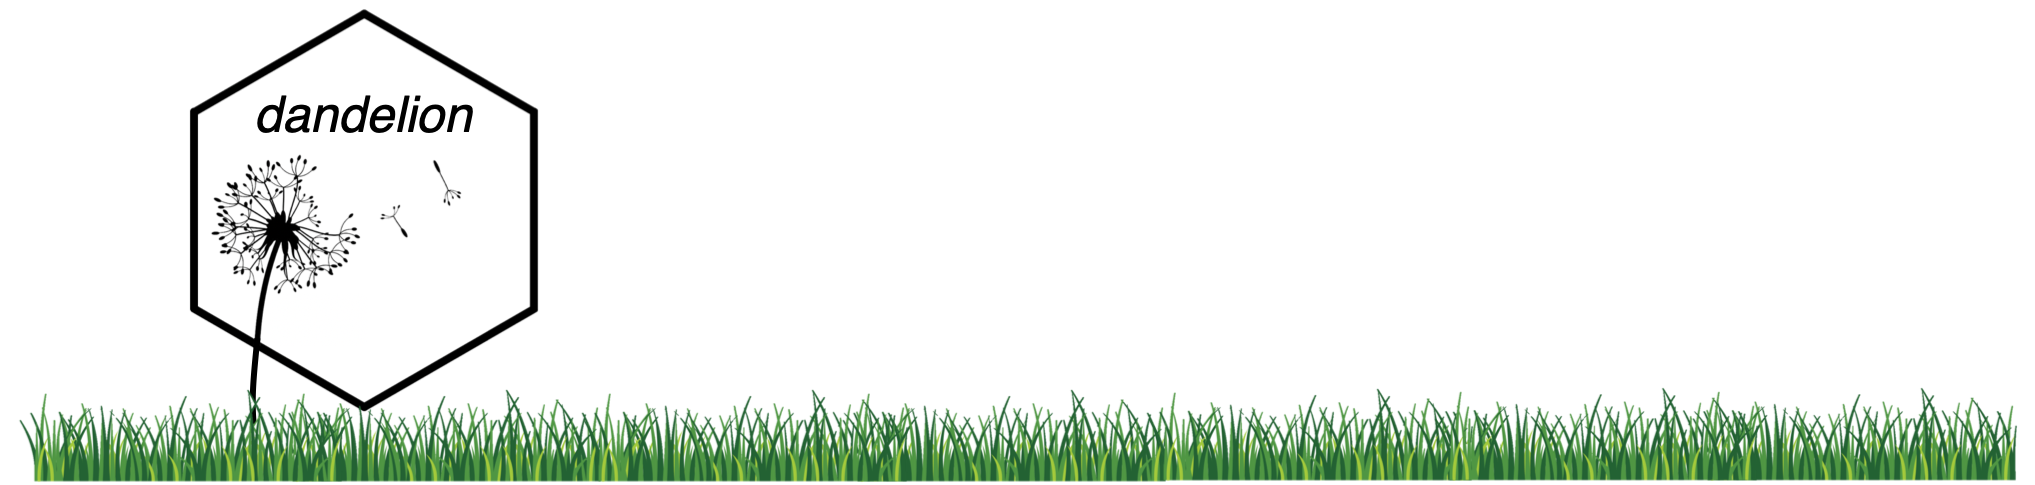

## Filtering
Now that the most boring part of the pre-proceesing is done in part 1, we can move on to more interesting things, that is to use *scanpy* to filter out cells (and corresponding contigs) that we would not be interested in analyzing because of quality or other issues.

#### Import *dandelion* module

In [1]:
import os
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion'))
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/PIP/'))

/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


#### Import modules for use with scanpy

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata

warnings.filterwarnings('ignore')
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


#### Set up some variables and again, prepare the dictionary for sample id swapping
From this point onwards, I will just work with one sample to keep things simple. Pan_T7918901 is the BCR-seq sample of a spleen sample so it should have lots of B cells.

In [3]:
sample = 'Pan_T7918901'
bcr_folder = 'Pan_Immune_BCR/'
gex_folder = 'Pan_Immune_GEX/'
sampledict = ddl.utl.dict_from_table('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/dandelion_files/meta/PIP_sampleInfo_kt16.txt', columns = ('SANGER SAMPLE ID', 'GEX_SAMPLE_ID')) # optional
meta = pd.read_csv('Pan_Immune_meta/PIP_sampleInfo_kt16.csv', dtype = 'object')

#### Setting up dictionaries from the meta data to let me add the info to the obs slot

In [4]:
sampleid = dict(zip(meta['SANGER SAMPLE ID'],meta['SANGER SAMPLE ID']))
gender = dict(zip(meta['SANGER SAMPLE ID'],meta['GENDER']))
donor = dict(zip(meta['SANGER SAMPLE ID'],meta['SANGERID']))
tissue = dict(zip(meta['SANGER SAMPLE ID'],meta['TISSUE']))
experiment = dict(zip(meta['SANGER SAMPLE ID'],meta['COMMENTS']))

#### Import the transcriptome data and populate the obs slot with meta data

In [5]:
inputfolder=gex_folder+sampledict[sample]+'/filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(inputfolder)
adata.obs['sampleid'] = sampleid[sampledict[sample]]
adata.obs['gender'] = gender[sampledict[sample]]
adata.obs['donor'] = donor[sampledict[sample]]
adata.obs['tissue'] = tissue[sampledict[sample]]
adata.obs['experiment'] = experiment[sampledict[sample]]
# rename cells to sample id + barcode, cleaving the trailing -1
adata.obs_names = [str(sampledict[sample])+'_'+str(j).split('-')[0] for j in adata.obs_names]
adata

AnnData object with n_obs × n_vars = 4002 × 33694 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment'
    var: 'gene_ids', 'feature_types'

#### Run basic scanpy pipeline
I've included a wrapper called `pp.ext.run_scanpy_qc` to run through a generic [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) workflow that includes [scrublet](https://github.com/AllonKleinLab/scrublet) doublet detection. The function does not filter the cells and is simply a way to mark bad quality cells and potential doublets in the obs slot. The scrublet doublet detection is implemented based on [kp9](kp9@sanger.ac.uk)'s "Bertie"'s doublet calling [procedure](https://www.nature.com/articles/s41467-018-06318-7).

Whether or not you run this is up to you. You can provide in a pre-processed `AnnData` object for the subsequent steps

In [6]:
adata = ddl.pp.ext.run_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 4002 × 33694 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna'
    var: 'gene_ids', 'feature_types'

The wrapper doesn't actually filter any cells, but just populate the *.obs* slot with the following headers.
```
'n_genes'
'percent_mito'
'n_counts'
'is_doublet'
'filter_rna'
```
Only `'filter_rna'` is needed for the next step.

If you have a pre-processed/filltered `AnnData` object that is ready, just add a `'filter_rna'` column into the *.obs* slot with every value set to `False` and you should be good to go:

```python
adata.obs['filter_rna'] = False
```

#### Filter cells that are potental doublets and poor quality in both the BCR data and transcriptome data
Ok now we use the tool function `tl.filter_bcr` to mark and filter out cells and contigs from both the BCR data and transcriptome data in `AnnData`.

Note that the `AnnData` object can hold non-B cells; I've written the functions from this point onwards to not be affected by cells without BCR info. You can filter it yourself to re-calculating the clusters and embeddings etc., but it's not necessary at this stage.

In [7]:
# point to the bcr file i'm going to work with
bcr_file = bcr_folder+sample+'/dandelion/data/all_contig_igblast_gap_genotyped.tsv'

# The function will return both objects. 
vdj, adata = ddl.tl.filter_bcr(bcr_file, adata)

Marking barcodes with poor quality BCRs and BCR doublets: 100%|██████████| 1852/1852 [00:02<00:00, 622.07it/s]
Annotating in anndata obs slot : 100%|██████████| 4002/4002 [00:00<00:00, 39486.90it/s]


The default mode is to filter any 'doublet' light chains, but some may be interested in keeping them. The option to change the behaviour is by toggling:
```python
filter_lightchains=False
```

Another default behavour is that if the cell in the BCR table cannot be found in the transcriptomic data, it will also be removed from the BCR data. This can be changed by toggling:
```python
filter_missing=False
```

#### Check the output vdj table
Note that the vdj table is indexed based on contigs (sequence_id).

In [8]:
vdj

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,cdr3_end,np1,np1_length,np2,np2_length,junction_aa_length,c_call,cell,sample,v_call_genotyped
sequence_id,,,,,,,,,,,,,,,,,,,,,
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1,Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1,GAGGAGTCAGACCCAGTCAGGACACAGCATGGACATGAGGGTCCCC...,FALSE,TRUE,IGKV1D-12*01,NaN,IGKJ5*01,GACATCCAGATGACCCAGTCTCCATCTTCTGTGTCTGCATCTTTAG...,GACATCCAGATGACCCAGTCTCCATCTTCTGTGTCTGCATCTGTAG...,TGTCTACAGGGTGAGAGTTACCCTCTCACCTTC,...,385,NaN,0,NaN,NaN,11,IGKC,Pan_T7917815_ACCTTTATCGCTTGTC,Pan_T7917815,IGKV1D-12*01
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2,Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2,AGCCTGCGAGGCGAAGATACGGCTATCTATTACTGTGCGAGTGATC...,FALSE,TRUE,"IGHV3-21*06,IGHV3-30*07,IGHV3-30*12",IGHD4-23*01,IGHJ4*02,.................................................,AATTCACTGTATCTGCAAATGAACAGCCTGAGAGCCGAGGACACNN...,TGTGCGAGTGATCCCCCTACTGCGGGAGACTACGGTGGCGGAGCCG...,...,90,TCCCCCTACTGCGGGA,16,CGGAGCCGAT,10,20,IGHG2,Pan_T7917815_ACCTTTATCGCTTGTC,Pan_T7917815,"IGHV3-21*06,IGHV3-30*07,IGHV3-30*12"
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1,Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1,TGGGGGAGAAGAGCTGCTCAGTTAGGACCCAGAGGGAACCATGGAA...,FALSE,TRUE,IGKV3-20*01,NaN,IGKJ1*01,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,TGTCAGCACTTTGGTAGCTCATCCTGGACGTTC,...,394,TCC,3,NaN,NaN,11,IGKC,Pan_T7917815_ACTGCTCCAGGTCGTC,Pan_T7917815,IGKV3-20*01
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2,Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2,GAGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCA...,FALSE,TRUE,IGHV3-21*01,IGHD4-23*01,IGHJ4*02,GAGGTGCAGTTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,TGTGCGAGAGGAGAGCGGGCGGCGGTAACCACCTACTGG,...,458,GAGAGCGGG,9,CAC,3,13,IGHM,Pan_T7917815_ACTGCTCCAGGTCGTC,Pan_T7917815,IGHV3-21*01
Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1,Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1,AGAGAGCCCTGGGGAGGAACTGCTCAGTTAGGACCCAGAGGGAACC...,FALSE,TRUE,IGKV3-11*01,NaN,IGKJ4*01,GAGATTGTGTTGACTCAGTCTCCAGTCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACACAGTCTCCAGCCACCCTGTCTTTGTCTCCAG...,TGTCAGCAGCGTAGCAACTGGCCTCCGCTCACTTTC,...,400,NaN,0,NaN,NaN,12,IGKC,Pan_T7917815_CCTACCAGTGCCTTGG,Pan_T7917815,IGKV3-11*01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2,Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2,GGCAGAAGTCTCTCTCAGTCAGGACACAGCATGGACATGAGGGTCC...,FALSE,TRUE,IGKV1-27*01,NaN,IGKJ1*01,GACATCCAGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTAG...,GACATCCAGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTAG...,TGTCAAAAGTATTCCAATGTTCCCTGGACGTTC,...,387,TTCCC,5,NaN,NaN,11,IGKC,Pan_T7917815_TTGCCGTCAAGTCTGT,Pan_T7917815,IGKV1-27*01
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1,Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1,GGACACCCTGTGCAGGAGTCAGACCCAGTCAGGACACAGCATGGAC...,FALSE,TRUE,"IGKV1-12*01,IGKV1-12*02,IGKV1D-12*02",NaN,IGKJ2*01,GACATCCAGATGACCCAGTCTCCATCTTCCGTGTCTGCATCTGTAG...,GACATCCAGATGACCCAGTCTCCATCTTCCGTGTCTGCATCTGTAG...,TGTCAACAGGCTAACAGTTTCCCGTACACTTTT,...,397,NaN,0,NaN,NaN,11,IGKC,Pan_T7917815_GTACTCCAGCCACTAT,Pan_T7917815,"IGKV1-12*01,IGKV1-12*02,IGKV1D-12*02"
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2,Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2,GAGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCA...,FALSE,TRUE,IGHV3-21*01,IGHD4-23*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,TGTGCGAGTGATCCCCCTACTGCGGGAGACTACGGTGGCGGAGCCG...,...,479,TCCCCCTACTGCGGGA,16,CGGAGCCGAT,10,20,IGHG2,Pan_T7917815_GTACTCCAGCCACTAT,Pan_T7917815,IGHV3-21*01


#### Check the AnnData object as well
And the `AnnData` object is indexed based on cells.

In [9]:
adata

View of AnnData object with n_obs × n_vars = 816 × 33694 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light'
    var: 'gene_ids', 'feature_types'

#### Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data
Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual stuff here.

In [10]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

Trying to set attribute `.var` of view, copying.


#### Identify highly-variable genes

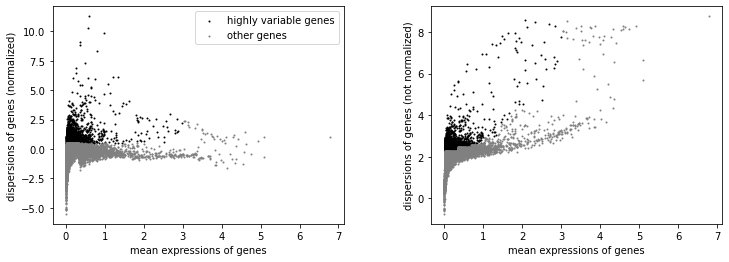

In [11]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

#### Filter the genes to only those marked as highly-variable

In [12]:
adata = adata[:, adata.var.highly_variable]

#### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.Scale the data to unit variance.

In [13]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'sampleid' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'gender' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


#### Run PCA

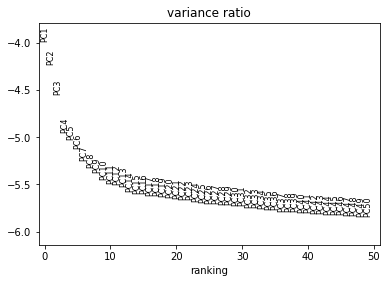

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

#### Computing the neighborhood graph, umap and clusters

In [15]:
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
# Embedding the neighborhood graph
sc.tl.umap(adata, min_dist = 0.3)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

#### Visualizing the clusters and whether or not there's a corresponding BCR

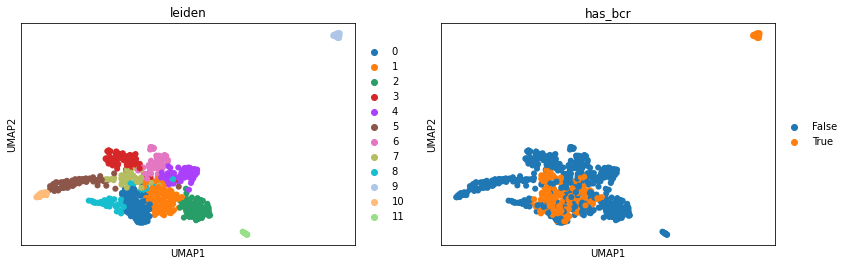

In [16]:
sc.pl.umap(adata, color=['leiden', 'has_bcr'])

#### Visualizing some B cell genes

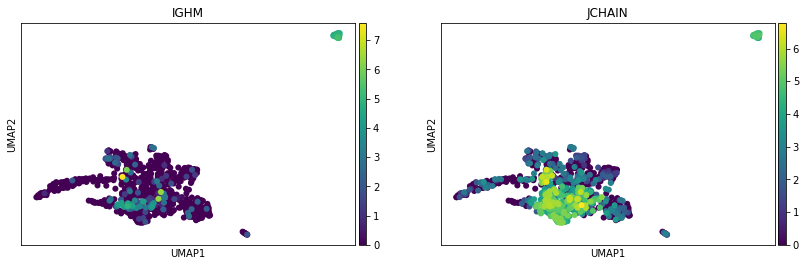

In [17]:
sc.pl.umap(adata, color=['IGHM', 'JCHAIN'])

#### Save the AnnData file
That's it! We can save this `AnnData` object for now and take a break. The vdj table is already saved from the filtering step earlier, with the suffix `filtered` appended to the filename.

In [18]:
adata.write(bcr_folder+sample+'/dandelion/data/adata.h5ad', compression = 'gzip')

... storing 'feature_types' as categorical


#### The number of cells that's actually has a matching BCR can be tabluated

In [19]:
pd.crosstab(adata.obs['has_bcr'], adata.obs['sampleid'])

sampleid,Pan_T7917815
has_bcr,
False,577
True,239
